
<center><h1>The Annotated Transformer</h1> </center>


<center>
<p><a href="https://arxiv.org/abs/1706.03762">Attention is All You Need</a></p>
</center>

<img src="images/aiayn.png" width="70%"/>

* *v2022: Austin Huang, Suraj Subramanian, Jonathan Sum, Khalid Almubarak, and Stella Athena.*
* *[Original](https://nlp.seas.harvard.edu/2018/04/03/attention.html): [Sasha Rush](http://rush-nlp.com/).*


The Transformer has been on a lot of
people's minds over the last <s>year</s> five years. 
This post presents an annotated version of the paper in the
form of a line-by-line implementation. It reorders and deletes
some sections from the original paper and adds comments
throughout. This document itself is a working notebook, and should
be a completely usable implementation.
Code is available [here](https://github.com/harvardnlp/annotated-transformer/).




<h3> Table of Contents </h3>
<ul>
<li><a href="#prelims">Prelims</a></li>
<li><a href="#background">Background</a></li>
<li><a href="#part-1-model-architecture">Part 1: Model Architecture</a></li>
<li><a href="#model-architecture">Model Architecture</a><ul>
<li><a href="#encoder-and-decoder-stacks">Encoder and Decoder Stacks</a></li>
<li><a href="#position-wise-feed-forward-networks">Position-wise Feed-Forward Networks</a></li>
<li><a href="#embeddings-and-softmax">Embeddings and Softmax</a></li>
<li><a href="#positional-encoding">Positional Encoding</a></li>
<li><a href="#full-model">Full Model</a></li>
<li><a href="#inference">Inference:</a></li>
</ul></li>
<li><a href="#part-2-model-training">Part 2: Model Training</a></li>
<li><a href="#training">Training</a><ul>
<li><a href="#batches-and-masking">Batches and Masking</a></li>
<li><a href="#training-loop">Training Loop</a></li>
<li><a href="#training-data-and-batching">Training Data and Batching</a></li>
<li><a href="#hardware-and-schedule">Hardware and Schedule</a></li>
<li><a href="#optimizer">Optimizer</a></li>
<li><a href="#regularization">Regularization</a></li>
</ul></li>
<li><a href="#a-first-example">A First Example</a><ul>
<li><a href="#synthetic-data">Synthetic Data</a></li>
<li><a href="#loss-computation">Loss Computation</a></li>
<li><a href="#greedy-decoding">Greedy Decoding</a></li>
</ul></li>
<li><a href="#part-3-a-real-world-example">Part 3: A Real World Example</a><ul>
<li><a href="#data-loading">Data Loading</a></li>
<li><a href="#iterators">Iterators</a></li>
<li><a href="#training-the-system">Training the System</a></li>
</ul></li>
<li><a href="#additional-components-bpe-search-averaging">Additional Components: BPE, Search, Averaging</a></li>
<li><a href="#results">Results</a><ul>
<li><a href="#attention-visualization">Attention Visualization</a></li>
<li><a href="#encoder-self-attention">Encoder Self Attention</a></li>
<li><a href="#decoder-self-attention">Decoder Self Attention</a></li>
<li><a href="#decoder-src-attention">Decoder Src Attention</a></li>
</ul></li>
<li><a href="#conclusion">Conclusion</a></li>
</ul>

# Prelims

<a href="#background">Skip</a>

numpy和matplotlib没啥说的，pytorch就是numpy的一个augograd,
tensor, GPU的高级封装。Matplotlib是画图的大神级package，这里将会使用到其绘制mask矩阵，位置编码等的示例化表示。Spacy（负责做负责管理机器翻译的一些公开数据集，例如IWSLT-国际口语翻译worksop），和torchtext（tokenize ，简单理解tokenize就是类似于，把句子Jack’s mom is crying. 的标点符号和词分开：Jack ’s mom is crying .）。

为了方便循序渐进的理解，我们先从第一个基本的class开始：

顾名思义，Embeddings类主要负责对输入的source sequence和target

sequence的词嵌入表示的映射，具体为每个词从one-hot表示，映射为d_model维度的一个向量。这样的话，如果有10个词，d_model为512的时候，则我们得到的是一个10*512的矩阵。每一行是512列，代表一个词的dense表示。


“In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation”,
这句话，在没有理解他们的一篇ACL的使用词根做机器翻译的论文的前提下，其实不容易理解。例如，在做欧洲语系和英语翻译的时候，很多词是共享词根的，所以，他们这个源语言和目标语言共享一个词嵌入矩阵有一定的道理。如果是中文和英文之间，则完全没有共享词嵌入矩阵的必要。

In [ ]:
#!pip install -r requirements.txt # torch11.0+cu11.3
# !python -m spacy download de_core_news_sm
# !python -m spacy download en_core_web_sm
# torchdata==0.3.0
# torchtext==0.11.2
# spacy==3.2
# altair==4.1
# jupytext==1.13
# flake8
# black
# GPUtil
# wandb

In [2]:
# 更新版
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import numpy as np
import altair as alt #数据可视化（jupyter lab）
# alt.renderers.enable('mimetype')
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
import spacy
import GPUtil # 获取GPU状态
import warnings
warnings.filterwarnings("ignore")
# 多GPU分布运算
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP

In [10]:
# Some convenience helper functions used throughout the notebook
# Set to False to skip notebook execution (e.g. for debugging)
RUN_EXAMPLES = True

def is_interactive_notebook():
    return __name__ == "__main__"


def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)


def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)


class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None


class DummyScheduler:
    def step(self):
        None

> My comments are blockquoted. The main text is all from the paper itself.

# Background


The goal of reducing sequential computation also forms the
foundation of the Extended Neural GPU, ByteNet and ConvS2S, all of
which use convolutional neural networks as basic building block,
computing hidden representations in parallel for all input and
output positions. In these models, the number of operations required
to relate signals from two arbitrary input or output positions grows
in the distance between positions, linearly for ConvS2S and
logarithmically for ByteNet. This makes it more difficult to learn
dependencies between distant positions. In the Transformer this is
reduced to a constant number of operations, albeit at the cost of
reduced effective resolution due to averaging attention-weighted
positions, an effect we counteract with Multi-Head Attention.

Self-attention, sometimes called intra-attention is an attention
mechanism relating different positions of a single sequence in order
to compute a representation of the sequence. Self-attention has been
used successfully in a variety of tasks including reading
comprehension, abstractive summarization, textual entailment and
learning task-independent sentence representations. End-to-end
memory networks are based on a recurrent attention mechanism instead
of sequencealigned recurrence and have been shown to perform well on
simple-language question answering and language modeling tasks.

To the best of our knowledge, however, the Transformer is the first
transduction model relying entirely on self-attention to compute
representations of its input and output without using sequence
aligned RNNs or convolution.

减少顺序计算的目标也构成了扩展神经GPU，ByteNet和ConvS2S的基础，所有这些都使用卷积神经网络作为基本构建块，并行计算所有输入和输出位置的隐藏表示。在这些模型中，关联来自两个任意输入或输出位置的信号所需的操作数量在位置之间的距离上增加，对于ConvS2S是线性增长的，对于ByteNet是线性增长的。这使得学习远处位置之间的依赖关系变得更加困难。在 Transformer 中，这被简化为恒定数量的操作，尽管代价是由于平均注意力加权位置而降低了有效分辨率，我们通过多头注意抵消了这种效果。

自我注意，有时称为内注意是一种注意机制，将单个序列的不同位置联系起来，以计算序列的表示。自我注意已成功用于各种任务，包括阅读理解，抽象总结，文本蕴含和学习与任务无关的句子表示。端到端记忆网络基于递归注意机制，而不是序列排列的递归，并且已被证明在简单语言问答和语言建模任务中表现良好。

然而，据我们所知，Transformer是第一个完全依靠自注意来计算其输入和输出表示的转导模型，而无需使用序列对齐的RNN或卷积。

# Part 1: Model Architecture
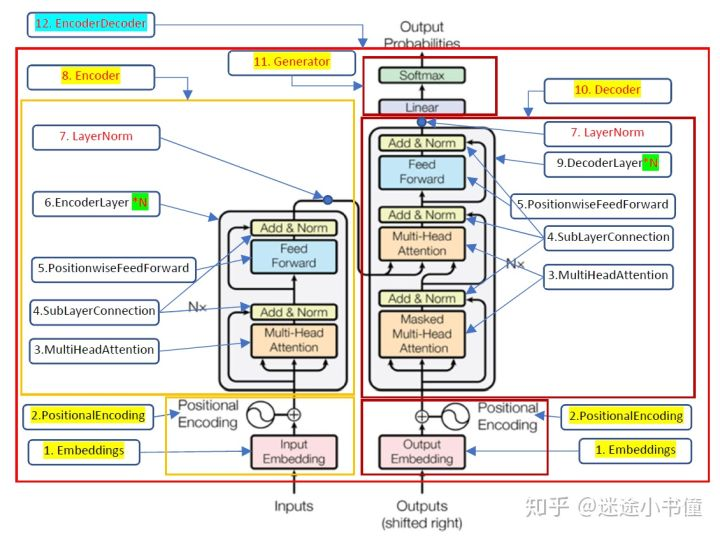
<center>图1 Transformer的总图（和代码class类名结合的）<center>
图1是基于原始论文中的transformer的总图，为每个部分标识出了其具体的对应的class name（类名）。为了方便记忆，这里对每个类class进行了编号1到12。

先看最外边，12 classEncoderDecoder，是个总类，这个类包括五个主要部分：

1. Embeddings和PositionalEncoding（两者通过torch.nn.Sequential来串起来使用）: 左下角的，是输入序列的word embedding + positional encoding;

2. Embeddings和PositionalEncoding(两者通过torch.nn.Sequential来串起来使用): 右下角的，是输出序列（训练阶段是完整的输出序列+mask，测试阶段是到当前位置为止的输出序列+mask）

3. Encoder：左边中央位置，负责管理6层EncoderLayer，以及一个最后的LayerNorm（做带有可训练参数的，批标准化），需要注意的是，原文的LayerNorm，命名有问题，其实不是LayerNorm，因为这个类，并没有被用于接到每个EncoderLayer的后边，而是6层EncoderLayer之后，只接一个LayerNorm，所以称为EncoderNorm或者DecoderNorm（Decoder的部分也类似）更合适，简化期间，可以称为CoderNorm (Coder表示Encoder或者Decoder)。

4. Decoder: 右边中央位置，负责管理6层DecoderLayer，以及一个最后的LayerNorm（带有可训练参数的，批标准化）

5. Generator: 包括一个全连接层和一个softmax层，负责把top-N 候选输出序列找出来。

# Model Architecture


Most competitive neural sequence transduction models have an
encoder-decoder structure
[(cite)](https://arxiv.org/abs/1409.0473). Here, the encoder maps an
input sequence of symbol representations $(x_1, ..., x_n)$ to a
sequence of continuous representations $\mathbf{z} = (z_1, ...,
z_n)$. Given $\mathbf{z}$, the decoder then generates an output
sequence $(y_1,...,y_m)$ of symbols one element at a time. At each
step the model is auto-regressive
[(cite)](https://arxiv.org/abs/1308.0850), consuming the previously
generated symbols as additional input when generating the next.

大多数竞争性的神经序列转导模型都具有编码器 - 解码器结构（引用）。在这里，编码器将符号表示的输入序列 $（x_1， ...， x_n）$ 映射到连续表示序列 $\mathbf{z} = （z_1， ...， z_n）$。给定 $\mathbf{z}$，解码器然后生成一个输出序列 $（y_1,...,y_m）$ 的符号，一次一个元素。在每个步骤中，模型都是自动回归的（引用），在生成下一个符号时使用先前生成的符号作为附加输入。

In [3]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        # Encoder对象
        self.decoder = decoder
        # Decoder对象
        self.src_embed = src_embed
        # 源语言序列的编码，包括词嵌入和位置编码
        self.tgt_embed = tgt_embed
        # 目标语言序列的编码，包括词嵌入和位置编码
        self.generator = generator
        # 生成器

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

        # 先对源语言序列进行编码，
        # 结果作为memory传递给目标语言的编码器

    def encode(self, src, src_mask):
        # src = (batch.size, seq.length)
        # src_mask 负责对src加掩码
        return self.encoder(self.src_embed(src), src_mask)
        # 对源语言序列进行编码，得到的结果为
        # (batch.size, seq.length, 512)的tensor

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
        # 对目标语言序列进行编码，得到的结果为
        # (batch.size, seq.length, 512)的tensor

上面的类里面，有五大属性，分别的可训练参数的个数是：

（假设源语言和目标语言的词表都是30,000)

源语言的Embeddings+Encoder，一共有34,275,328个可训练参数 (Embedding+Encoder);


假设目标语言也是30,000的词表大小，则又增加30,000 * 512=15,360,000个参数，从而有：40,585,216个可训练参数(Embedding+Decoder);


如果假设trg_vocab_size=30,000, 则可训练参数的个数是：

512*30000 + 30000 = 15,390,000个(Generator).


合计为：90,250,544个参数，9千万。稍稍扩大一下词表大小，轻松一亿个参数。所以，170亿参数，也没啥。


当然，实际词嵌入矩阵，一般的维度小于512，可以是100维，200维等。


In [4]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."

    def __init__(self, d_model, vocab):
        # d_model=512
        # vocab = 目标语言词表大小
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
        # 定义一个全连接层，可训练参数个数是(512 * trg_vocab_size) + trg_vocab_size

    def forward(self, x):
        return log_softmax(self.proj(x), dim=-1) # [-inf, 0)扩大可学范围，词表小的话直接用softmax
        # x 类似于 (batch.size, sequence.length, 512)
        # -> proj 全连接层 (30, 10, trg_vocab_size) = logits
        # 对最后一个维度执行log_soft_max
        # 得到(30, 10, trg_vocab_size)

$\text{LogSoftmax}(x_{i}) = \log\left(\frac{\exp(x_i) }{ \sum_j \exp(x_j)} \right)$

上面类里面有一个全连接层，参数个数是，一个权重矩阵 512*trg_vocab_size，一个偏移向量 (trg_vocab_size)。

如果假设trg_vocab_size=30,000, 则可训练参数的个数是：

512*30000 + 30000 = 15,390,000个 (Generator)。


The Transformer follows this overall architecture using stacked
self-attention and point-wise, fully connected layers for both the
encoder and decoder, shown in the left and right halves of Figure 1,
respectively.

Transformer遵循这种整体架构，为编码器和解码器使用堆叠的自注意层和逐点、完全连接的层，分别如图1的左半部分和右半部分所示。

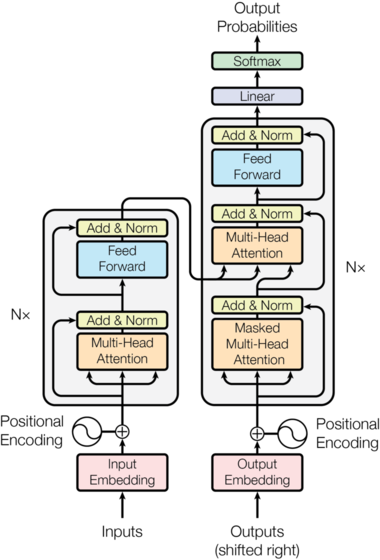

![](images/ModalNet-21.png)

## Encoder and Decoder Stacks

### Encoder

The encoder is composed of a stack of $N=6$ identical layers.

下面这个clones方法，实现一个网络的深copy，也就是说一个新的对象，和原来的对象，完全分离，不分享任何存储空间：（从而保证可训练参数，都有自己的取值，梯度）

In [5]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])
    # 这里没有要求顺序，所以可以不用nn.Sequential(copy.deepcopy(module) for _ in range(N))

In [6]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"

    def __init__(self, layer, N):
        # layer = one EncoderLayer object, N=6
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        # 深copy，N=6，
        self.norm = LayerNorm(layer.size)
        # 定义一个LayerNorm，layer.size=d_model=512
        # 其中有两个可训练参数a_2和b_2

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        # x is alike (30, 10, 512)
        # (batch.size, sequence.len, d_model)
        # mask是类似于(batch.size, 10, 10)的矩阵
        for layer in self.layers:
            x = layer(x, mask)
            # 进行六次EncoderLayer操作
        return self.norm(x)
        # 最后做一次LayerNorm，最后的输出也是(30, 10, 512) shape


We employ a residual connection
[(cite)](https://arxiv.org/abs/1512.03385) around each of the two
sub-layers, followed by layer normalization
[(cite)](https://arxiv.org/abs/1607.06450).

我们在两个子层中的每一个周围使用残差连接（引用），然后是层规范化（引用）。

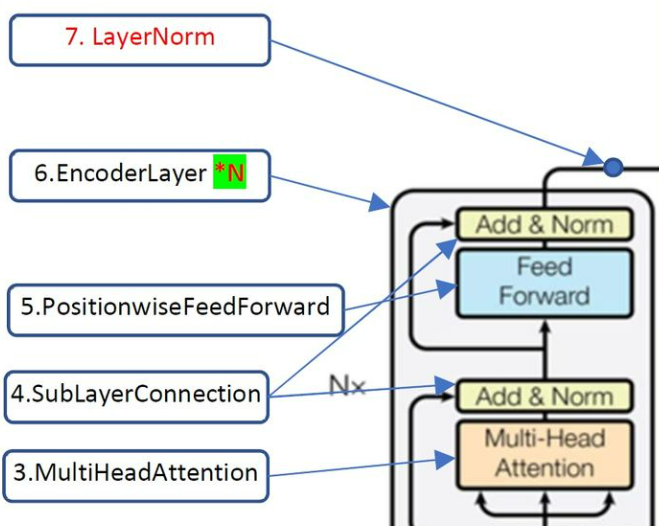
我们继续看下一个类，4.SubLayerConnection 子层连接：

所谓SubLayer，指的是两个部分：3.MultiHeadAttention以及4.PositionwiseFeedForward。特别要提的一点是，这两个子层的输入和输出，都是类似于(batch.size, sequence.length, d_model)这样的tensor。

我们提前先看一下要对一个SubLayer进行Norm所需要的一个类7.LayerNorm:（更正一下，这个类用来对每个sublayer的输出进行处理，也对6层EncoderLayer之后的输出进行处理！）

本篇章会做个比较难的挑战：**统计出来transformer中的可训练参数的个数**。

In [7]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    # LN：对每个序列中每个词进行归一化
    # d2l归一化公式

    def __init__(self, features, eps=1e-6):
        # features=d_model=512, eps=epsilon 用于分母的非0化平滑
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        # a_2 是一个可训练参数向量，(512)
        self.b_2 = nn.Parameter(torch.zeros(features))
        # b_2 也是一个可训练参数向量, (512)
        self.eps = eps

    def forward(self, x):
        # x 的形状为(batch.size, sequence.len, 512)
        mean = x.mean(-1, keepdim=True)
        # 对x的最后一个维度，取平均值，得到tensor (batch.size, seq.len)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
        # 本质上类似于（x-mean)/std，不过这里加入了两个可训练向量
        # a_2 and b_2，以及分母上增加一个极小值epsilon，用来防止std为0的时候的除法溢出

上面这个类有两个可训练参数，a_2和b_2，分别是(512)维度的向量。


That is, the output of each sub-layer is $\mathrm{LayerNorm}(x +
\mathrm{Sublayer}(x))$, where $\mathrm{Sublayer}(x)$ is the function
implemented by the sub-layer itself.  We apply dropout
[(cite)](http://jmlr.org/papers/v15/srivastava14a.html) to the
output of each sub-layer, before it is added to the sub-layer input
and normalized.

To facilitate these residual connections, all sub-layers in the
model, as well as the embedding layers, produce outputs of dimension
$d_{\text{model}}=512$.

也就是说，每个子层的输出是 $\mathrm{LayerNorm}（x + \mathrm{Sublayer}（x））$，其中 $\mathrm{Sublayer}（x）$ 是由子层本身实现的函数。我们将 dropout （cite） 应用于每个子层的输出，然后将其添加到子层输入并规范化。

为了促进这些残差连接，模型中的所有子层以及嵌入层都会生成维度$d_{\text{model}}=512$ 的输出。

SubLayerConnection类主要实现两个功能，残差Add以及Norm（使用上面的LayerNorm类）：

In [8]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        # size=d_model=512; dropout=0.1
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)  # (512)，用来定义a_2和b_2
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        # x is alike (batch.size, sequence.len, 512)
        # sublayer是一个具体的MultiHeadAttention
        #或者PositionwiseFeedForward对象
        return x + self.dropout(sublayer(self.norm(x)))
        # x (30, 10, 512) -> norm (LayerNorm) -> (30, 10, 512)
        # -> sublayer (MultiHeadAttention or PositionwiseFeedForward)
        # -> (30, 10, 512) -> dropout -> (30, 10, 512)

        # 然后输入的x（没有走sublayer) + 上面的结果，
        #即实现了残差相加的功能

上面这个类，没有自己的可训练参数。(self.norm里面，即LayerNorm类，有1024个可训练参数）
单batch单word：x + sublayer(self.norm(x)) 512 + 512


Each layer has two sub-layers. The first is a multi-head
self-attention mechanism, and the second is a simple, position-wise
fully connected feed-forward network.

每层有两个子层。第一个是多头自注意机制，第二个是简单的，位置全连接的前馈网络。

In [10]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"

    def __init__(self, size, self_attn, feed_forward, dropout):
        # size=d_model=512
        # self_attn = MultiHeadAttention对象, first sublayer
        # feed_forward = PositionwiseFeedForward对象，second sublayer
        # dropout = 0.1 (e.g.)
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        # 使用深度克隆方法，完整地复制出来两个SublayerConnection
        self.size = size # 512

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        # x shape = (30, 10, 512)
        # mask 是(batch.size, 10,10)的矩阵，类似于当前一个词w，有哪些词是w可见的
        # 源语言的序列的话，所有其他词都可见，除了"<blank>"这样的填充；
        # 目标语言的序列的话，所有w的左边的词，都可见。
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        # x (30, 10, 512) -> self_attn (MultiHeadAttention) 
        # shape is same (30, 10, 512) -> SublayerConnection 
        # -> (30, 10, 512)
        return self.sublayer[1](x, self.feed_forward)
        # x 和feed_forward对象一起，给第二个SublayerConnection

可以看到EncoderLayer没有自己独立的可训练参数，所有的参数，都来自其他地方：

其一，一个MultiHeadAttention对象，里面有4个Linear network；参数个数是：4*(512*512+512)=1,050,624

其二，一个PositionwiseFeedForward对象，里面有2个Linear network；参数个数是：2,099,712。

其三，两个SublayerConnection对象，每个对象使用一个LayerNorm对象，LayerNorm里面有两个可训练参数向量a_2和b_2。则，可训练参数个数是：

2 * (512 + 512) = 2048。

综合上面三个部分：一共有: 1,050,624 + 2,099,712 + 2048 = 3,152,384个参数。（一个EncoderLayer)

另外稍微难理解的是这里使用了lambda来定义一个匿名函数，展开类似于：

def lambda1(self, x, mask):

  return self.self_attn(x, x, x, mask) 

然后把这个lambda1传递给self.sublayer[0]。

数数这里的可训练参数的个数：

6层EncoderLayers: 每一层是 3,152,384个参数；

LayerNorm里面有两个512维度的向量，有1024个参数；

则一共有：3,152,384*6 + 1,024 = 18,915,328个参数(Encoder类)。

再假设，源语言词表大小是30,000词，则embeddings部分有30,000 * 512 = 15,360,000个参数（词嵌入矩阵）。

这样的话，源语言的Embeddings+Encoder，一共有34,275,328个可训练参数。

### Decoder

The decoder is also composed of a stack of $N=6$ identical layers.


因为很多类都是重复使用的，我们看第一个不一样的类, 9.DecoderLayer

In [11]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."

    def __init__(self, layer, N):
        # layer = DecoderLayer object
        # N = 6
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        # 深度copy六次DecoderLayer
        self.norm = LayerNorm(layer.size)
         # 初始化一个LayerNorm

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
            # 执行六次DecoderLayer
        return self.norm(x)
        # 执行一次LayerNorm


In addition to the two sub-layers in each encoder layer, the decoder
inserts a third sub-layer, which performs multi-head attention over
the output of the encoder stack.  Similar to the encoder, we employ
residual connections around each of the sub-layers, followed by
layer normalization.

除了每个编码器层中的两个子层外，解码器还插入第三个子层，该子层对编码器堆栈的输出执行多头注意。与编码器类似，我们在每个子层周围采用残余连接，然后进行层归一化。

Decoder类的可训练参数的个数是：

其一，六层DecoderLayer: 6*4,204,032；

其二，一个LayerNorm, 1,024个参数；

则一共有：6*4,204,032 + 1024 = 25,225,216个参数。


如果假设目标语言也是30,000的词表大小，则又增加30,000 * 512=15,360,000个参数，从而有：40,585,216个可训练参数。


In [12]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"

    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        # size = d_model=512,
        # 1 self_attn = one MultiHeadAttention object，目标语言序列的
        # 2 src_attn = second MultiHeadAttention object, 目标语言序列
        # 和源语言序列之间的
        # 3 feed_forward 一个全连接层
        # dropout = 0.1
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        # 需要三个SublayerConnection, 分别在
        # self.self_attn, self.src_attn, 和self.feed_forward的后边

    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory # (batch.size, sequence.len, 512) ，(encode k，v)
        # 来自源语言序列的Encoder之后的输出，作为memory
        # 供目标语言的序列检索匹配：（类似于alignment in SMT)
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask)) #maks后面的tgt
        # 通过一个匿名函数，来实现目标序列的自注意力编码
        # 结果扔给sublayer[0]:SublayerConnection
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask)) #mask src的<pad>
        # 通过第二个匿名函数，来实现目标序列和源序列的注意力计算
        # 结果扔给sublayer[1]:SublayerConnection
        return self.sublayer[2](x, self.feed_forward)
        # 走一个全连接层，然后
        # 结果扔给sublayer[2]:SublayerConnection

这里估计一下DecoderLayer的可训练参数的个数：

其一，两个MultiHeadAttention对象，每个对象有1,050,624个参数；

其二，feedforward对象，2,099,712个参数；

其三，三个SublayerConnection, 3*(512+512) = 3,072个参数。

综合起来有，2*1,050,624 + 2,099,712 + 3,072 = 4,204,032个参数 (DecoderLayer)。


We also modify the self-attention sub-layer in the decoder stack to
prevent positions from attending to subsequent positions.  This
masking, combined with fact that the output embeddings are offset by
one position, ensures that the predictions for position $i$ can
depend only on the known outputs at positions less than $i$.

我们还修改了解码器堆栈中的自注意子层，以防止位置关注后续位置。这种掩码，结合输出嵌入偏移一个位置的事实，确保了对位置的预测，只能依赖于小于以下位置的已知输出

In [13]:
def subsequent_mask(size):
    "Mask out subsequent positions."
     # e.g., size=10
    attn_shape = (1, size, size)# (1, 10, 10)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(torch.uint8)
    # triu: 负责生成一个三角矩阵，k-th对角线以下都是设置为0 
    # 上三角中元素为1.
    return subsequent_mask == 0
    # 反转上面的triu得到的上三角矩阵，修改为下三角矩阵。

这里的k=1，1号对角线，不太容易理解：举例子如下：

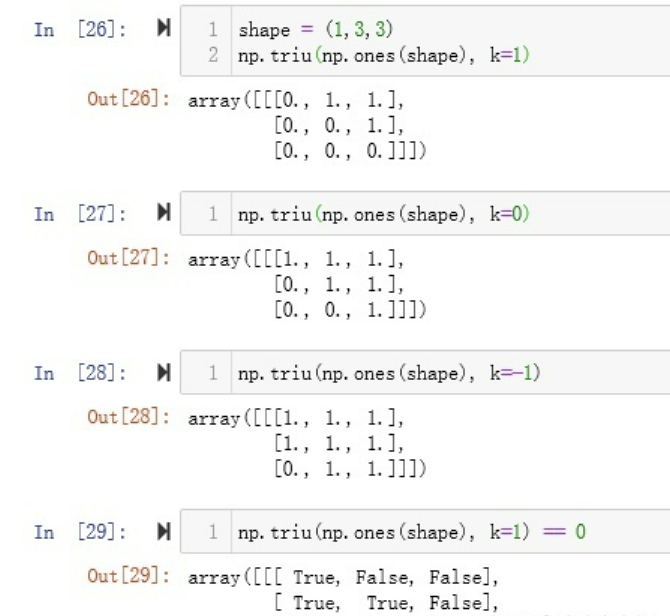


> Below the attention mask shows the position each tgt word (row) is
> allowed to look at (column). Words are blocked for attending to
> future words during training.

注意掩码下方显示允许每个 tgt 字（行）查看的位置（列）。单词被阻止，以便在训练期间注意未来的单词。

In [ ]:
def example_mask():
    LS_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Subsequent Mask": subsequent_mask(20)[0][x, y].flatten(),
                    "Window": y,
                    "Masking": x,
                }
            )
            for y in range(20)
            for x in range(20)
        ]
    )

    return (
        alt.Chart(LS_data)
        .mark_rect()
        .properties(height=250, width=250)
        .encode(
            alt.X("Window:O"),
            alt.Y("Masking:O"),
            alt.Color("Subsequent Mask:Q", scale=alt.Scale(scheme="viridis")),
        )
        .interactive()
    )


show_example(example_mask)

### Attention

An attention function can be described as mapping a query and a set
of key-value pairs to an output, where the query, keys, values, and
output are all vectors.  The output is computed as a weighted sum of
the values, where the weight assigned to each value is computed by a
compatibility function of the query with the corresponding key.

We call our particular attention "Scaled Dot-Product Attention".
The input consists of queries and keys of dimension $d_k$, and
values of dimension $d_v$.  We compute the dot products of the query
with all keys, divide each by $\sqrt{d_k}$, and apply a softmax
function to obtain the weights on the values.



![](images/ModalNet-19.png)

注意力函数可以描述为将查询和一组键值对映射到输出，其中查询、键、值和输出都是向量。输出计算为值的加权和，其中分配给每个值的权重由具有相应键的查询的兼容性函数计算。

我们将特别关注称为“缩放点积关注”。输入由维度 $d_k$ 的查询和键以及维度 $d_v$ 的值组成。我们使用所有键计算查询的点积，将每个键除以 $\sqrt{d_k}$，然后应用 softmax 函数来获取值的权重。


In practice, we compute the attention function on a set of queries
simultaneously, packed together into a matrix $Q$.  The keys and
values are also packed together into matrices $K$ and $V$.  We
compute the matrix of outputs as:

$$
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$

在实践中，我们同时计算一组查询的注意力函数，这些查询打包成一个矩阵$Q$。键和值也打包成矩阵$K$ 和 $V$。我们将输出矩阵计算为：

$$\mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V$$

In [28]:
def attention(query, key, value, mask=None, dropout=None):
# query, key, value的形状类似于(30, 8, 10, 64), (30, 8, 11, 64), (30, 8, 11, 64)，
# 例如30是batch.size，即当前batch中有多少一个序列；
# 8=head.num，注意力头的个数；
# 10=目标序列中词的个数，64是每个词对应的向量表示 ，开始符没算；
# 11=源语言序列传过来的memory中，当前序列的词的个数，
# 64是每个词对应的向量表示。
# 类似于，这里假定query来自target language sequence；
# key和value都来自source language sequence.   
    "Compute 'Scaled Dot Product Attention'"    
    d_k = query.size(-1) # 64=d_k
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k) # 先是(30,8,10,64)和(30, 8, 64, 11)相乘，
    #（注意是最后两个维度相乘）得到(30,8,10,11)，
    #代表10个目标语言序列中每个词和11个源语言序列的分别的“亲密度”。
    #然后除以sqrt(d_k)=8，防止过大的亲密度。
    #这里的scores的shape是(30, 8, 10, 11)
    if mask is not None: 
        scores = scores.masked_fill(mask == 0, -1e9) 
    #使用mask，对已经计算好的scores，按照mask矩阵，填-1e9，
    #然后在下一步计算softmax的时候，被设置成-1e9的数对应的值~0,被忽视
    p_attn = F.softmax(scores, dim = -1) 
    #对scores的最后一个维度执行softmax，得到的还是一个tensor, 
    #(30, 8, 10, 11)
    if dropout is not None: 
        p_attn = dropout(p_attn) #执行一次dropout
    return torch.matmul(p_attn, value), p_attn
#返回的第一项，是(30,8,10, 11)乘以（最后两个维度相乘）
#value=(30,8,11,64)，得到的tensor是(30,8,10,64)，
#和query的最初的形状一样。另外，返回p_attn，形状为(30,8,10,11). 
#注意，这里返回p_attn主要是用来可视化显示多头注意力机制。


The two most commonly used attention functions are additive
attention [(cite)](https://arxiv.org/abs/1409.0473), and dot-product
(multiplicative) attention.  Dot-product attention is identical to
our algorithm, except for the scaling factor of
$\frac{1}{\sqrt{d_k}}$. Additive attention computes the
compatibility function using a feed-forward network with a single
hidden layer.  While the two are similar in theoretical complexity,
dot-product attention is much faster and more space-efficient in
practice, since it can be implemented using highly optimized matrix
multiplication code.


While for small values of $d_k$ the two mechanisms perform
similarly, additive attention outperforms dot product attention
without scaling for larger values of $d_k$
[(cite)](https://arxiv.org/abs/1703.03906). We suspect that for
large values of $d_k$, the dot products grow large in magnitude,
pushing the softmax function into regions where it has extremely
small gradients (To illustrate why the dot products get large,
assume that the components of $q$ and $k$ are independent random
variables with mean $0$ and variance $1$.  Then their dot product,
$q \cdot k = \sum_{i=1}^{d_k} q_ik_i$, has mean $0$ and variance
$d_k$.). To counteract this effect, we scale the dot products by
$\frac{1}{\sqrt{d_k}}$.  



两个最常用的注意力函数是加法注意（引用）和点积（乘法）注意。点积注意与我们的算法相同，除了比例因子$\frac{1}{\sqrt{d_k}}$.加法注意力使用具有单个隐藏层的前馈网络计算兼容性函数。虽然两者在理论复杂性上相似，但点积的注意力在实践中更快，更节省空间，因为它可以使用高度优化的矩阵乘法代码来实现。

而对于小值$d_k$这两种机制的表现相似，加法注意力优于点积注意力，无需缩放即可获得更大的值$d_k$（引用）.我们怀疑对于大值$d_k$，点积在幅度上变大，将softmax函数推入它具有极小梯度的区域（为了说明为什么点积变大，假设q和k是具有均值的独立随机变量0和方差1.然后是他们的点积，$q \cdot k = \sum_{i=1}^{d_k} q_ik_i$，具有平均值0和方差$d_k$.).为了抵消这种效应，我们通过以下方式缩放点积：$\frac{1}{\sqrt{d_k}}$.

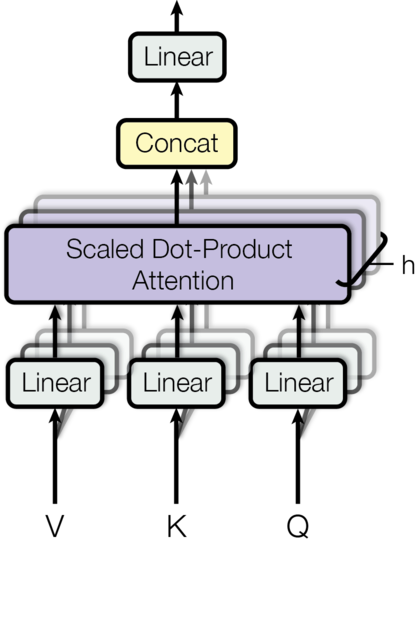

![](images/ModalNet-20.png)


Multi-head attention allows the model to jointly attend to
information from different representation subspaces at different
positions. With a single attention head, averaging inhibits this.

多头注意允许模型共同关注来自不同位置的不同表示子空间的信息。对于单个注意力头，平均可以抑制这一点。
$$
\mathrm{MultiHead}(Q, K, V) =
    \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O \\
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)
$$

Where the projections are parameter matrices(其中投影是参数矩阵 
) $W^Q_i \in
\mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in
\mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in
\mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in
\mathbb{R}^{hd_v \times d_{\text{model}}}$.

In this work we employ(在这项工作中，我们采用) $h=8$ parallel attention layers, or
heads. For each of these we use (对于其中的每一个，我们使用)$d_k=d_v=d_{\text{model}}/h=64$. Due
to the reduced dimension of each head, the total computational cost
is similar to that of single-head attention with full
dimensionality.(由于每个头部的尺寸减小，总计算成本与具有全维的单头注意力相似。)

理解了这个类，Transformer的精髓也就理解的差不多了，至于后面的Decoder或者Generator，如果自己的任务，不是双语翻译之类的，而是类似“预训练”，BERT，这种路线，则Decoder或者Generator可以完全简化。（只看一个Decoder+Generator足矣）
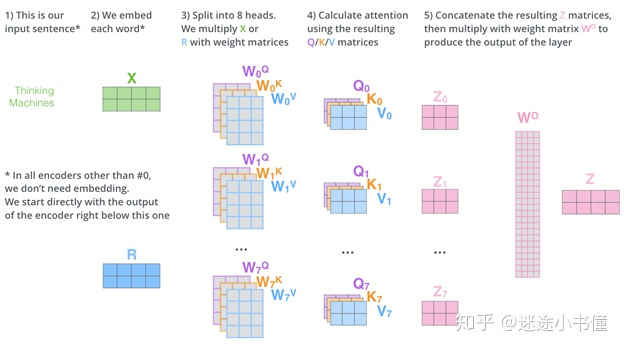

In [30]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        # h=8, d_model=512
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0 # 512%8=0
        # We assume d_v always equals d_k
        self.d_k = d_model // h # 64
        self.h = h # 8
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        #定义四个Linear networks, 每个的大小是(512, 512)的，
        #每个Linear network里面有两类可训练参数，Weights，
        #其大小为512*512，以及biases，其大小为512=d_model。

        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        #定义四个Linear networks, 每个的大小是(512, 512)的，
        #每个Linear network里面有两类可训练参数，Weights，
        #其大小为512*512，以及biases，其大小为512=d_model。

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        # 注意，输入query的形状类似于(30, 10, 512)，
        # key.size() ~ (30, 11, 512), 
        #以及value.size() ~ (30, 11, 512)
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1) # mask下回细细分解。
        nbatches = query.size(0) #e.g., nbatches=30

    # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]
        # 这里是前三个Linear Networks的具体应用，输出8个h的l(x):
        #例如query=(30,10, 512) ->*(512,512) = Linear network -> (30, 10, 512) 
        #-> view -> (30,10, 8, 64) -> transpose(1,2) -> (30, 8, 10, 64)
        #，其他的key和value也是类似地，
        #从(30, 11, 512) -> (30, 8, 11, 64)。
    # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout
        )
        #调用上面定义好的attention函数，输出的x形状为(30, 8, 10, 64)；
        #attn的形状为(30, 8, 10=target.seq.len, 11=src.seq.len)
    # 3) "Concat" using a view and apply a final linear.
        x = (
            x.transpose(1, 2)
            .contiguous() # view()张量内存空间必须连续，可以直接用reshape
            .view(nbatches, -1, self.h * self.d_k)
        )
       # x ~ (30, 8, 10, 64) -> transpose(1,2) -> 
       #(30, 10, 8, 64) -> contiguous() and view -> 
       #(30, 10, 8*64) = (30, 10, 512)
        del query
        del key
        del value
        return self.linears[-1](x)
      #执行第四个Linear network，把(30, 10, 512)经过一次linear network，
      #得到(30, 10, 512).

记得上次有个问题提出来了，source sequence是否需要mask，为什么？其实是需要的，因为一个batch里面，可能序列的长短不一，有些是10个词打满，有些可能只有8个词，则这个时候，剩下的2个词的位置会被填充为”$<blank>$”这样的词，从而mask的时候，需要知道哪些地方是”$<blank>$”，这些位置不参与softmax以及序列的整体向量化表示等进一步的计算。

### Applications of Attention in our Model

The Transformer uses multi-head attention in three different ways:
1) In "encoder-decoder attention" layers, the queries come from the
previous decoder layer, and the memory keys and values come from the
output of the encoder.  This allows every position in the decoder to
attend over all positions in the input sequence.  This mimics the
typical encoder-decoder attention mechanisms in sequence-to-sequence
models such as [(cite)](https://arxiv.org/abs/1609.08144).


2) The encoder contains self-attention layers.  In a self-attention
layer all of the keys, values and queries come from the same place,
in this case, the output of the previous layer in the encoder.  Each
position in the encoder can attend to all positions in the previous
layer of the encoder.


3) Similarly, self-attention layers in the decoder allow each
position in the decoder to attend to all positions in the decoder up
to and including that position.  We need to prevent leftward
information flow in the decoder to preserve the auto-regressive
property.  We implement this inside of scaled dot-product attention
by masking out (setting to $-\infty$) all values in the input of the
softmax which correspond to illegal connections.

Transformer以三种不同的方式使用多头注意力：

1）在“编码器 - 解码器注意”层中，查询来自前一个解码器层，内存键和值来自编码器的输出。这允许解码器中的每个位置都参与输入序列中的所有位置。这模仿了序列到序列模型中的典型编码器- 解码器注意机制，例如（cite）。

2） 编码器包含自注意层。在自注意层中，所有键、值和查询都来自同一位置，在本例中，是编码器中前一层的输出。编码器中的每个位置都可以处理编码器前一层中的所有位置。

3）类似地，解码器中的自注意层允许解码器中的每个位置都关注解码器中的所有位置，直到并包括该位置。我们需要阻止解码器中向左的信息流，以保持自回归属性。我们通过遮罩（设置为−∞） 输入中与非法连接相对应的所有 softmax 值。


## Position-wise Feed-Forward Networks

In addition to attention sub-layers, each of the layers in our
encoder and decoder contains a fully connected feed-forward network,
which is applied to each position separately and identically.  This
consists of two linear transformations with a ReLU activation in
between.

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$

While the linear transformations are the same across different
positions, they use different parameters from layer to
layer. Another way of describing this is as two convolutions with
kernel size 1.  The dimensionality of input and output is
$d_{\text{model}}=512$, and the inner-layer has dimensionality
$d_{ff}=2048$.

除了注意力子层之外，我们的编码器和解码器中的每个层都包含一个完全连接的前馈网络，该网络分别以相同的方式应用于每个位置。这由两个线性变换组成，中间有一个 ReLU 激活。

虽然线性变换在不同位置上是相同的，但它们在各个层之间使用不同的参数。另一种描述方式是内核大小为 1 的两个卷积。输入和输出的维数为$d_{\text{model}}=512$，内层的维数$d_{ff}=2048$。

PositionwiseFeedForward类相对简单，就是一个全连接层：

In [17]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        # d_model = 512
        # d_ff = 2048 = 512*4
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        # 构建第一个全连接层，(512, 2048)，其中有两种可训练参数：
        # weights矩阵，(512, 2048)，以及
        # biases偏移向量, (2048)
        self.w_2 = nn.Linear(d_ff, d_model)
        # 构建第二个全连接层, (2048, 512)，两种可训练参数：
        # weights矩阵，(2048, 512)，以及
        # biases偏移向量, (512)
        self.dropout = nn.Dropout(dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape = (batch.size, sequence.len, 512)
        # 例如, (30, 10, 512)
        return self.w_2(self.dropout(self.w_1(x).relu()))
        # x (30, 10, 512) -> self.w_1 -> (30, 10, 2048)
        # -> relu -> (30, 10, 2048)
        # -> dropout -> (30, 10, 2048)
        # -> self.w_2 -> (30, 10, 512)是输出的shape

其，实现的是：
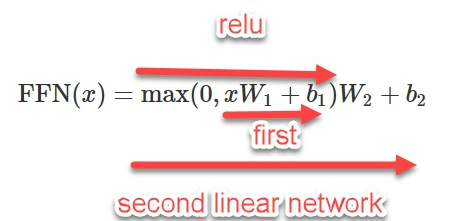
FFN(x)=max(0,xW1+b1)W2+b2

其中max(0, xW1 + b1) 是一个ReLU激活函数。

上面的可训练参数包括两个权重矩阵，(512, 2048)以及(2048, 512)，以及两个偏移bias向量，(2048)和(512)。则总共的可训练参数的个数是：2*512*2048 + 2048 + 512 = 2,099,712。一个全连接层，轻松达到2百万个参数。


## Embeddings and Softmax

Similarly to other sequence transduction models, we use learned
embeddings to convert the input tokens and output tokens to vectors
of dimension $d_{\text{model}}$.  We also use the usual learned
linear transformation and softmax function to convert the decoder
output to predicted next-token probabilities.  In our model, we
share the same weight matrix between the two embedding layers and
the pre-softmax linear transformation, similar to
[(cite)](https://arxiv.org/abs/1608.05859). In the embedding layers,
we multiply those weights by $\sqrt{d_{\text{model}}}$.

与其他序列转导模型类似，我们使用学习的嵌入将输入标记和输出标记转换为维度$d_{\text{model}}$ 的向量。我们还使用通常学习的线性变换和softmax函数将解码器输出转换为预测的下一个令牌概率。在我们的模型中，我们在两个嵌入层和前softmax线性变换之间共享相同的权重矩阵，类似于（引用）。在嵌入层中，我们将这些权重乘以 $\sqrt{d_{\text{model}}}$。

顾名思义，Embeddings类主要负责对输入的source sequence和target

sequence的词嵌入表示的映射，具体为每个词从one-hot表示，映射为d_model维度的一个向量。这样的话，如果有10个词，d_model为512的时候，则我们得到的是一个10*512的矩阵。每一行是512列，代表一个词的dense表示。

“In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation”,
这句话，在没有理解他们的一篇ACL的使用词根做机器翻译的论文的前提下，其实不容易理解。例如，在做欧洲语系和英语翻译的时候，很多词是共享词根的，所以，他们这个源语言和目标语言共享一个词嵌入矩阵有一定的道理。如果是中文和英文之间，则完全没有共享词嵌入矩阵的必要。

In [19]:
class Embeddings(nn.Module):
    def __init__(self,d_model,vocab):
    #d_model=512, vocab=当前语言的词表大小
        super(Embeddings,self).__init__()
        self.lut=nn.Embedding(vocab,d_model) 
    # one-hot转词嵌入(新版torch可学习)，这里有一个待训练的可学习矩阵E(bert)，大小是vocab*d_model
        self.d_model=d_model # 512
    def forward(self,x): 
     # x ~ (batch.size, sequence.length, one-hot), 
     #one-hot大小=vocab，当前语言的词表大小
         return self.lut(x)*math.sqrt(self.d_model) 
     # 得到的10*512词嵌入矩阵，主动乘以sqrt(512)=22.6，
     #这里我做了一些对比，感觉这个乘以sqrt(512)没啥用… 求反驳。
     #这里的输出的tensor大小类似于(batch.size, sequence.length, 512)

## Positional Encoding

Since our model contains no recurrence and no convolution, in order
for the model to make use of the order of the sequence, we must
inject some information about the relative or absolute position of
the tokens in the sequence.  To this end, we add "positional
encodings" to the input embeddings at the bottoms of the encoder and
decoder stacks.  The positional encodings have the same dimension
$d_{\text{model}}$ as the embeddings, so that the two can be summed.
There are many choices of positional encodings, learned and fixed
[(cite)](https://arxiv.org/pdf/1705.03122.pdf).

In this work, we use sine and cosine functions of different frequencies:

$$PE_{(pos,2i)} = \sin(pos / 10000^{2i/d_{\text{model}}})$$

$$PE_{(pos,2i+1)} = \cos(pos / 10000^{2i/d_{\text{model}}})$$

where $pos$ is the position and $i$ is the dimension.  That is, each
dimension of the positional encoding corresponds to a sinusoid.  The
wavelengths form a geometric progression from $2\pi$ to $10000 \cdot
2\pi$.  We chose this function because we hypothesized it would
allow the model to easily learn to attend by relative positions,
since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a
linear function of $PE_{pos}$.

In addition, we apply dropout to the sums of the embeddings and the
positional encodings in both the encoder and decoder stacks.  For
the base model, we use a rate of $P_{drop}=0.1$.



由于我们的模型不包含重复和卷积，为了使模型利用序列的顺序，我们必须注入一些关于序列中令牌的相对或绝对位置的信息。为此，我们将“位置编码”添加到编码器和解码器堆栈底部的输入嵌入中。位置编码与嵌入具有相同的维度 $d_{\text{model}}$，因此可以对两者求和。有许多位置编码的选择，学习和固定（引用）。

在这项工作中，我们使用不同频率的正弦和余弦函数：
$$
\begin{aligned}
PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}})\\
PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})
\end{aligned}
$$
其中 $pos$ 是位置，$i$ 是维度。也就是说，位置编码的每个维度都对应于一个正弦波。波长形成从 $2\pi$ 到 $10000 \cdot 2\pi$ 的几何级数。我们之所以选择这个函数，是因为我们假设它将允许模型轻松学习通过相对位置来关注，因为对于任何固定的偏移$k$，$PE_{pos+k}$ 可以表示为$PE_{pos}$的线性函数。

此外，我们还对编码器和解码器堆栈中的嵌入和位置编码的总和应用 dropout。对于基本模型，我们使用$P_{drop}=0.1$的速率。

注意，位置编码不会更新，是写死的，所以这个class里面没有可训练的参数。

为了计算这个公式，上面的代码写的比较风骚，以2i为偶数为例子：
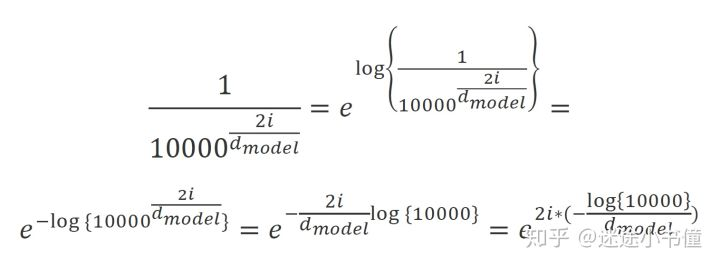
其中2i，是步长为2的0, 2, 4, …, 4998; d_model=512.

有了1.Embeddings和2.PositionalEncoding；在具体使用的时候，是通过torch.nn.Sequential来把他们两个串起来的：

nn.Sequential(Embeddings(d_model,src_vocab),
  PositionalEncoding(d_model,dropout)) 
  
例如，d_model=512, src_vocab=源语言的词表大小, dropout=0.1即 dropout rate

In [20]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        #d_model=512,dropout=0.1,
        #max_len=5000代表事先准备好长度为5000的序列的位置编码，其实没必要，
        #一般100或者200足够了。
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        #(5000,512)矩阵，保持每个位置的位置编码，一共5000个位置，
        #每个位置用一个512维度向量来表示其位置编码
        position = torch.arange(0, max_len).unsqueeze(1)
        # (5000) -> (5000,1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        # (0,2,…, 4998)一共准备2500个值，供sin, cos调用
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)].requires_grad_(False)
        # 接受1.Embeddings的词嵌入结果x，
        #然后把自己的位置编码pe，封装成torch的Variable(不需要梯度)，加上去。
        #例如，假设x是(30,10,512)的一个tensor，
        #30是batch.size, 10是该batch的序列长度, 512是每个词的词嵌入向量；
        #则该行代码的第二项是(1, min(10, 5000), 512)=(1,10,512)，
        #在具体相加的时候，会扩展(1,10,512)为(30,10,512)，
        #保证一个batch中的30个序列，都使用（叠加）一样的位置编码。
        # 增加一次dropout操作
        return self.dropout(x)
    
        # 注意，位置编码不会更新，是写死的，所以这个class里面没有可训练的参数。


> Below the positional encoding will add in a sine wave based on
> position. The frequency and offset of the wave is different for
> each dimension.

我们还尝试使用学习的位置嵌入（引用），发现这两个版本产生了几乎相同的结果。我们之所以选择正弦版本，是因为它可能允许模型推断出比训练期间遇到的序列长度更长的序列长度。

In [ ]:
def example_positional():
    pe = PositionalEncoding(20, 0)
    y = pe.forward(torch.zeros(1, 100, 20))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[0, :, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )


show_example(example_positional)


We also experimented with using learned positional embeddings
[(cite)](https://arxiv.org/pdf/1705.03122.pdf) instead, and found
that the two versions produced nearly identical results.  We chose
the sinusoidal version because it may allow the model to extrapolate
to sequence lengths longer than the ones encountered during
training.

我们还尝试使用学习的位置嵌入（引用），发现这两个版本产生了几乎相同的结果。我们之所以选择正弦版本，是因为它可能允许模型推断出比训练期间遇到的序列长度更长的序列长度。

## Full Model

> Here we define a function from hyperparameters to a full model.

在这里，我们定义一个函数，该函数采用超参数并生成实例化一个完整模型。

In [22]:
def make_model(
    src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1
):
    # src_vocab = 源语言词表大小
    # tgt_vocab = 目标语言词表大小
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy # 对象的深度copy/pytorch自带的clone() ，这里拷贝的是编解码层数N
    attn = MultiHeadedAttention(h, d_model)# 8, 512 ：构造一个MultiHeadAttention对象
    
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    # 512, 2048, 0.1
    # 构造一个feed forward对象
    position = PositionalEncoding(d_model, dropout) # 位置编码
    
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab),
    )

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1: #标量不初始化
            nn.init.xavier_uniform_(p)
    return model # 用xavier_uniform初始化model参数

In [23]:
# Small example model.(self)
tmp_model = make_model(1000, 1000, 6, 256)
# src_vocab_size = 1000
# tgt_vocab_size = 1000
# N = 6, number for EncoderLayer and DecoderLayer
# d_model=256
None

## Inference:

> Here we make a forward step to generate a prediction of the
model. We try to use our transformer to memorize the input. As you
will see the output is randomly generated due to the fact that the
model is not trained yet. In the next tutorial we will build the
training function and try to train our model to memorize the numbers
from 1 to 10.

在这里，我们向前迈出了一步，以生成模型的预测。我们尝试使用我们的转换器来记忆输入。正如您将看到的，由于模型尚未训练，输出是随机生成的。在下一个教程中，我们将构建训练函数并尝试训练我们的模型来记住从 1 到 10 的数字。

# Part 2: Model Training

# Training

This section describes the training regime for our models.


> We stop for a quick interlude to introduce some of the tools
> needed to train a standard encoder decoder model. First we define a
> batch object that holds the src and target sentences for training,
> as well as constructing the masks.

我们停下来一会儿，介绍一些训练标准编码器解码器模型所需的工具。首先，我们定义一个批处理对象，用于保存用于训练的 src 和目标句子，以及构造掩码$<pad>$。

## Batches and Masking

In [33]:
class Batch:
    """Object for holding a batch of data with mask during training."""

    def __init__(self, src, tgt=None, pad=2):  # 2 = <blank> for IWST数据集，WMT为0
        # src: 源语言序列，(batch.size, src.seq.len)
        # 二维tensor，第一维度是batch.size；第二个维度是源语言句子的长度
        # 例如：[ [2,1,3,4], [2,3,1,4] ]这样的二行四列的，
        # 1-4代表每个单词word的id
        
        # trg: 目标语言序列，默认为空，其shape和src类似
        # (batch.size, trg.seq.len)，
        #二维tensor，第一维度是batch.size；第二个维度是目标语言句子的长度
        # 例如trg=[ [2,1,3,4], [2,3,1,4] ] for a "copy network"
        # (输出序列和输入序列完全相同）
        
        # pad: 源语言和目标语言统一使用的位置填充符号，'<blank>'
        # 所对应的id，这里默认为0
        # 例如，如果一个source sequence，长度不到4，则在右边补0
        # [1,2] -> [1,2,0,0]
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        # src = (batch.size, seq.len) -> != pad -> 
        # (batch.size, seq.len) -> usnqueeze ->
        # (batch.size, 1, seq.len) 相当于在倒数第二个维度扩展
        # e.g., src=[ [2,1,3,4], [2,3,1,4] ]对应的是(2,4)
        # src_mask=[ [[1,1,1,1]], 这里的1为True，0为False
        #            [[1,1,1,1]] ](2,1,4)
        if tgt is not None:
            self.tgt = tgt[:, :-1]# 重要
            # trg 相当于目标序列的前N-1个单词的序列
            #（去掉了最后一个词<end>）
            self.tgt_y = tgt[:, 1:]
            # trg_y 相当于目标序列的后N-1个单词的序列
            # (去掉了第一个词<start>）
            # 训练：目的是(src + trg) 来预测出来(id)与tgt_y比较产生loss
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    # 静态装饰器
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        # 这里的tgt类似于：
        #[ [2,1,3], [2,3,1] ] （最初的输入目标序列，分别去掉了最后一个词）
        # pad=0, '<blank>'的id编号
        tgt_mask = (tgt != pad).unsqueeze(-2)
        # 得到的tgt_mask类似于
        # tgt_mask = tensor([[[1, 1, 1]],[[1, 1, 1]]], dtype=torch.uint8)
        # shape=(2,1,3)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data)
        return tgt_mask
        # 先看subsequent_mask, 其输入的是tgt.size(-1)=3
        # 这个函数的输出为= tensor([[[1, 0, 0],
        # [1, 1, 0],
        # [1, 1, 1]]], dtype=torch.uint8)
        # type_as 把这个tensor转成tgt_mask.data的type(也是torch.uint8)
        
        # 这样的话，&的两边的tensor分别是(2,1,3), (1,3,3);
        #tgt_mask = tensor([[[1, 1, 1]],[[1, 1, 1]]], dtype=torch.uint8)
        #and
        # tensor([[[1, 0, 0], [1, 1, 0], [1, 1, 1]]], dtype=torch.uint8)
        
        # (2,3,3)就是得到的tensor
        # tgt_mask.data = tensor([[[1, 0, 0],
        # [1, 1, 0],
        # [1, 1, 1]],

        #[[1, 0, 0],
        # [1, 1, 0],
        # [1, 1, 1]]], dtype=torch.uint8)

需要仔细看的是上面的 & 这个算子

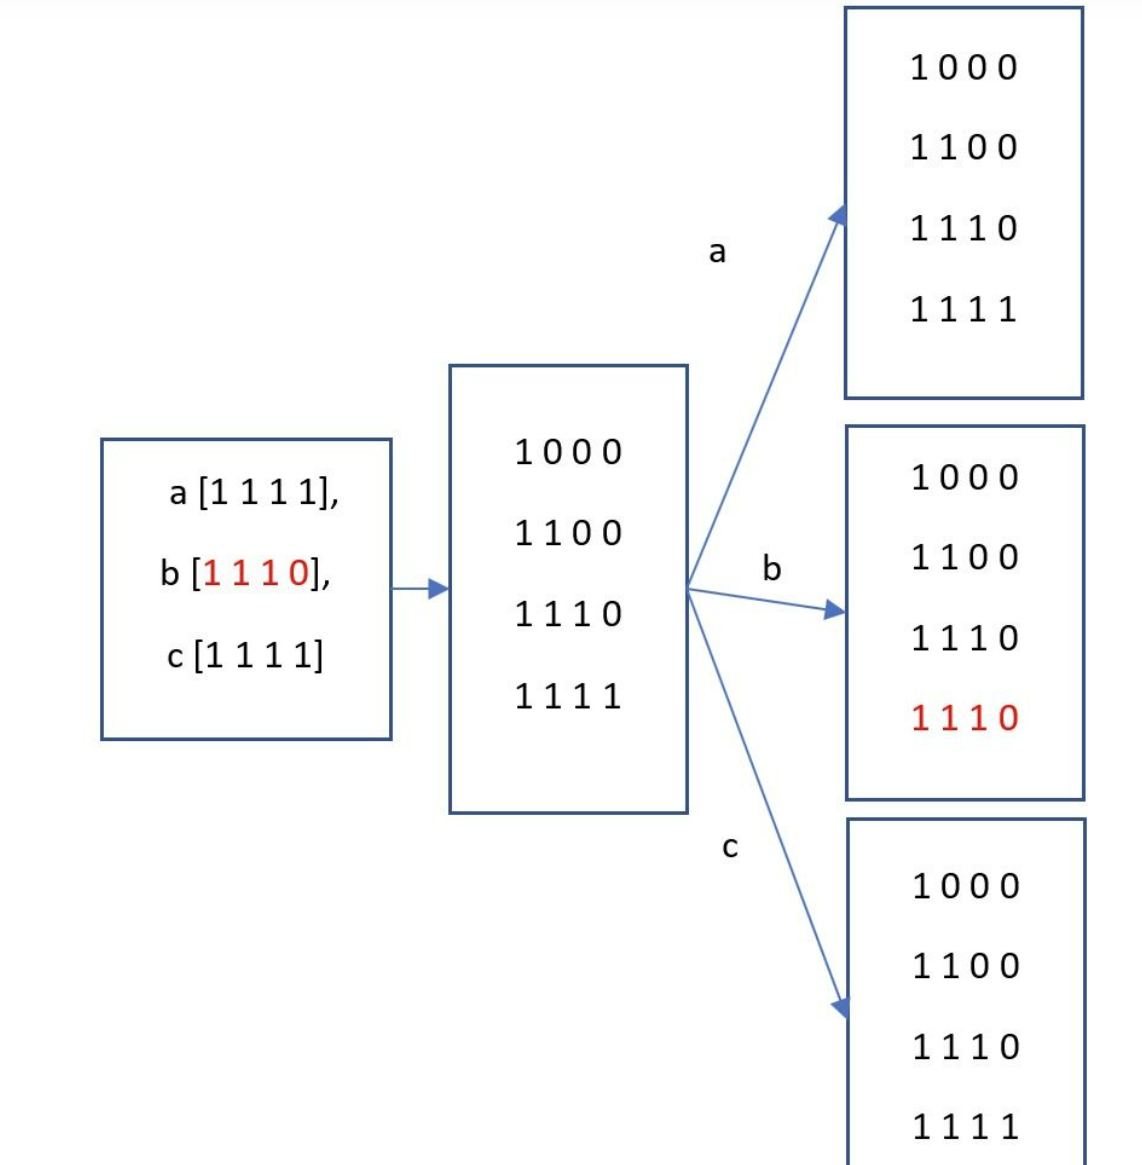


> Next we create a generic training and scoring function to keep
> track of loss. We pass in a generic loss compute function that
> also handles parameter updates.

接下来，我们创建一个通用训练和评分函数来跟踪损失。我们传入一个通用损失计算函数，该函数还处理参数更新。

## Training Loop

In [34]:
class TrainState:
    """Track number of steps, examples, and tokens processed"""

    step: int = 0  # Steps in the current epoch
    accum_step: int = 0  # Number of gradient accumulation steps
    samples: int = 0  # total  of examples used
    tokens: int = 0  # total  of tokens processed

In [35]:
def run_epoch(
    data_iter,
    model,
    loss_compute,
    optimizer,
    scheduler,
    mode="train",
    accum_iter=1,# 设置梯度更新同batch批次
    train_state=TrainState(),# 默认各个类属性为0，int
):
    """Train a single epoch"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        # 使用目前的model，对batch.src+batch.trg进行forward
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
        # out和trg_y计算Loss
        # ntokens = 6 (trg_y中非'<blank>'的token的个数)
        # 注意，这里是token,不是unique word
        # 例如[ [ [1, 2, 3], [2,3,4] ]中有6个token,而只有4个unique word
        
        # loss_node = loss_node / accum_iter
        if mode == "train" or mode == "train+log":
            loss_node.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens
            if i % accum_iter == 0: # 设置梯度更新同单个batch批次
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0
        del loss
        del loss_node
    return total_loss / total_tokens, train_state

## Training Data and Batching

We trained on the standard WMT 2014 English-German dataset
consisting of about 4.5 million sentence pairs.  Sentences were
encoded using byte-pair encoding, which has a shared source-target
vocabulary of about 37000 tokens. For English-French, we used the
significantly larger WMT 2014 English-French dataset consisting of
36M sentences and split tokens into a 32000 word-piece vocabulary.


Sentence pairs were batched together by approximate sequence length.
Each training batch contained a set of sentence pairs containing
approximately 25000 source tokens and 25000 target tokens.

我们在标准的 WMT 2014 英语-德语数据集上进行训练，该数据集包含约 450 万个句子对。句子使用字节对编码进行编码，该编码具有大约37000个令牌的共享源目标词汇表。对于英语 - 法语，我们使用的WMT 2014英语 - 法语数据集明显更大，该数据集由3600万个句子组成，并将标记拆分为32000个单词块词汇表。

句子对按近似序列长度一起批处理。每个训练批处理包含一组句子对，其中包含大约 25000 个源令牌和 25000 个目标令牌。

## Hardware and Schedule

We trained our models on one machine with 8 NVIDIA P100 GPUs.  For
our base models using the hyperparameters described throughout the
paper, each training step took about 0.4 seconds.  We trained the
base models for a total of 100,000 steps or 12 hours. For our big
models, step time was 1.0 seconds.  The big models were trained for
300,000 steps (3.5 days).

我们在一台装有 8 个 NVIDIA P100 GPU 的机器上训练了我们的模型。对于使用本文中描述的超参数的基本模型，每个训练步骤大约需要0.4秒。我们对基本模型进行了总共100，000步或12小时的训练。对于我们的大型模型，步长为1.0秒。大型模型经过300，000步（3.5天）的训练。

## Optimizer

We used the Adam optimizer [(cite)](https://arxiv.org/abs/1412.6980)
with $\beta_1=0.9$, $\beta_2=0.98$ and $\epsilon=10^{-9}$.  We
varied the learning rate over the course of training, according to
the formula:

$$
lrate = d_{\text{model}}^{-0.5} \cdot
  \min({step\_num}^{-0.5},
    {step\_num} \cdot {warmup\_steps}^{-1.5})
$$

This corresponds to increasing the learning rate linearly for the
first $warmup\_steps$ training steps, and decreasing it thereafter
proportionally to the inverse square root of the step number.  We
used $warmup\_steps=4000$.

预热调节学习率：这相当于线性增加第一个预热学习速率$warmup\_steps$，然后将其与步骤数的反平方根成比例地减小。我们使用$warmup\_steps = 4000$


> Note: This part is very important. Need to train with this setup
> of the model.


> Example of the curves of this model for different model sizes and
> for optimization hyperparameters.

该模型针对不同模型大小和优化超参数的曲线示例。

In [36]:
def rate(step, model_size, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

In [ ]:
# alt:
def example_learning_schedule():
    opts = [
        [512, 1, 4000],  # example 1
        [512, 1, 8000],  # example 2
        [256, 1, 4000],  # example 3
    ]

    dummy_model = torch.nn.Linear(1, 1)
    learning_rates = []

    # we have 3 examples in opts list.
    for idx, example in enumerate(opts):
        # run 20000 epoch for each example
        optimizer = torch.optim.Adam(
            dummy_model.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9
        )
        lr_scheduler = LambdaLR(
            optimizer=optimizer, lr_lambda=lambda step: rate(step, *example)
        )
        tmp = []
        # take 20K dummy training steps, save the learning rate at each step
        for step in range(20000):
            tmp.append(optimizer.param_groups[0]["lr"])
            optimizer.step()
            lr_scheduler.step()
        learning_rates.append(tmp)

    learning_rates = torch.tensor(learning_rates)

    # Enable altair to handle more than 5000 rows
    alt.data_transformers.disable_max_rows()

    opts_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Learning Rate": learning_rates[warmup_idx, :],
                    "model_size:warmup": ["512:4000", "512:8000", "256:4000"][
                        warmup_idx
                    ],
                    "step": range(20000),
                }
            )
            for warmup_idx in [0, 1, 2]
        ]
    )

    return (
        alt.Chart(opts_data)
        .mark_line()
        .properties(width=600)
        .encode(x="step", y="Learning Rate", color="model_size:warmup:N")
        .interactive()
    )


example_learning_schedule()

## Regularization

### Label Smoothing

During training, we employed label smoothing of value
$\epsilon_{ls}=0.1$ [(cite)](https://arxiv.org/abs/1512.00567).
This hurts perplexity, as the model learns to be more unsure, but
improves accuracy and BLEU score.

在培训期间，我们采用了价值的标签$\epsilon_{ls}=0.1$.这伤害了困惑，因为模型学会了更加不确定，但提高了准确性和BLEU分数。

下面进入有些难于理解的LabelSmoothing，简单思想就是劫富济贫。

这个方法虽然会损害Perplexity，但是会增加最后的BLEU score.

另外，这个名字不好，无论如何需要加上 KLLoss, 类似于：

LabelSmoothing -> LabelSmoothingKLLoss 其实是最终计算损失函数的。


> We implement label smoothing using the KL div loss. Instead of
> using a one-hot target distribution, we create a distribution that
> has `confidence` of the correct word and the rest of the
> `smoothing` mass distributed throughout the vocabulary.

我们使用 KL div 损失实现标签平滑。我们不是使用一个独热的目标分布，而是创建一个分布，其中包含正确的单词和分布在整个词汇表中的其余部分。confidencesmoothing

In [37]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."

    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction="sum")
        self.padding_idx = padding_idx # '<blank>' 的id
        self.confidence = 1.0 - smoothing # 自留的概率值、得分 e.g. 0.6
        self.smoothing = smoothing # 均分出去的概率值，得分 e.g. 0.4
        self.size = size  # target vocab size 目标语言词表大小
        self.true_dist = None

    def forward(self, x, target):
        "in real-world case: 真实情况下"
        #  x的shape为(batch.size * seq.len, target.vocab.size)
        # y的shape是(batch.size * seq.len)
        
        # x=logits，(seq.len, target.vocab.size)
        # 每一行，代表一个位置的词
        # 类似于：假设seq.len=3, target.vocab.size=5
        # x中保存的是log(prob)
        #x = tensor([[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233],
        #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233],
        #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233]])
        
        # target 类似于：
        # target = tensor([2, 1, 0])，torch.size=(3)
        assert x.size(1) == self.size # 目标语言词表大小
        true_dist = x.data.clone()
        # true_dist = tensor([[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233],
        #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233],
        #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233]])
        
        true_dist.fill_(self.smoothing / (self.size - 2))
        # true_dist = tensor([[0.1333, 0.1333, 0.1333, 0.1333, 0.1333],
        #[0.1333, 0.1333, 0.1333, 0.1333, 0.1333],
        #[0.1333, 0.1333, 0.1333, 0.1333, 0.1333]])
        
        # 注意，这里分母target.vocab.size-2是因为
        # (1) 最优值 0.6要占一个位置；
        # (2) 填充词 <blank> 要被排除在外
        # 所以被激活的目标语言词表大小就是self.size-2
        
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        # target.data.unsqueeze(1) -> 
        # tensor([[2],
        #[1],
        #[0]]); shape=torch.Size([3, 1])  
        # self.confidence = 0.6
        
        # 根据target.data的指示，按照列优先(1)的原则，把0.6这个值
        # 填入true_dist: 因为target.data是2,1,0的内容，
        # 所以，0.6填入第0行的第2列（列号，行号都是0开始）
        # 0.6填入第1行的第1列
        # 0.6填入第2行的第0列：
        # true_dist = tensor([[0.1333, 0.1333, 0.6000, 0.1333, 0.1333],
        #[0.1333, 0.6000, 0.1333, 0.1333, 0.1333],
        #[0.6000, 0.1333, 0.1333, 0.1333, 0.1333]])
        
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
         # true_dist = tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        #[0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        #[0.0000, 0.1333, 0.1333, 0.1333, 0.1333]])
        # 设置true_dist这个tensor的第一列的值全为0
        # 因为这个是填充词'<blank>'所在的id位置，不应该计入
        # 目标词表。需要注意的是，true_dist的每一列，代表目标语言词表
        #中的一个词的id
        
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
            # 当target reference序列中有0这个'<blank>'的时候，则需要把
            # 这一行的值都清空。
            # 在一个batch里面的时候，可能两个序列长度不一，所以短的序列需要
            # pad '<blank>'来填充，所以会出现类似于(2,1,0)这样的情况
            # true_dist = tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
            # [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
            # [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
        self.true_dist = true_dist
        return self.criterion(x, true_dist.clone().detach())
         # 这一步就是调用KL loss来计算
          # x = tensor([[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233],
          #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233],
          #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233]])
          
          # true_dist=tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
          # [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
          # [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
          # 之间的loss了。


> Here we can see an example of how the mass is distributed to the
> words based on confidence.

在这里，我们可以看到一个示例，说明质量如何根据置信度分布到单词中。

上图中，第0列，都是0，代表了'<blank>'的id位置；最后一行都是0，代表的是(2,1,0)中的最后一个词，对应的也是'$<blank>$'，所以最后一行都被设置为0.

这个类LabelSmoothing，一方面对label进行平滑，如果Model对于一个结果非常确信，则loss反而惩罚它（貌似缺少了多样性）；另外一方面则是对loss进行计算的。

下图很好的说明了，“过犹不及”的思想：

In [ ]:
# Example of label smoothing.
# alt:

def example_label_smoothing():
    crit = LabelSmoothing(5, 0, 0.4)
    predict = torch.FloatTensor(
        [
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
        ]
    )
    crit(x=predict.log(), target=torch.LongTensor([2, 1, 0, 3, 3]))
    LS_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "target distribution": crit.true_dist[x, y].flatten(),
                    "columns": y,
                    "rows": x,
                }
            )
            for y in range(5)
            for x in range(5)
        ]
    )

    return (
        alt.Chart(LS_data)
        .mark_rect(color="Blue", opacity=1)
        .properties(height=200, width=200)
        .encode(
            alt.X("columns:O", title=None),
            alt.Y("rows:O", title=None),
            alt.Color(
                "target distribution:Q", scale=alt.Scale(scheme="viridis")
            ),
        )
        .interactive()
    )


show_example(example_label_smoothing)


> Label smoothing actually starts to penalize the model if it gets
> very confident about a given choice.

标签平滑实际上开始惩罚模型，如果它对给定的选择非常有信心。

In [ ]:
# alt:
def loss(x, crit):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
    return crit(predict.log(), torch.LongTensor([1])).data


def penalization_visualization():
    crit = LabelSmoothing(5, 0, 0.1)
    loss_data = pd.DataFrame(
        {
            "Loss": [loss(x, crit) for x in range(1, 100)],
            "Steps": list(range(99)),
        }
    ).astype("float")

    return (
        alt.Chart(loss_data)
        .mark_line()
        .properties(width=350)
        .encode(
            x="Steps",
            y="Loss",
        )
        .interactive()
    )


show_example(penalization_visualization)

# A First  Example

> We can begin by trying out a simple copy-task. Given a random set
> of input symbols from a small vocabulary, the goal is to generate
> back those same symbols.

我们可以从尝试一个简单的复制任务开始。给定一组来自小词汇表的随机输入符号，目标是生成这些相同的符号。

现在用小数据集将单gpu跑通（本地or云），保存镜像；后面载将大数据集用多GPU作分布训练（云）

## Synthetic Data

生成数据集

In [43]:
def data_gen(V, batch_size, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.randint(1, V, size=(batch_size, 10))
        data[:, 0] = 1
        src = data.requires_grad_(False).clone().detach()
        tgt = data.requires_grad_(False).clone().detach()
        yield Batch(src, tgt, 0)

例如：

src = tensor([[1, 4, 2, 1],
[1, 4, 4, 4]], dtype=torch.int32)

tgt = tensor([[1, 4, 2, 1],
[1, 4, 4, 4]], dtype=torch.int32)

假设batch.size=2, source.vocab.size=4=target.vocab.size

## Loss Computation

封装的基于batch来计算loss的类：

In [44]:
class SimpleLossCompute:
    "A simple loss compute and train function."

    def __init__(self, generator, criterion):
        self.generator = generator
        self.criterion = criterion

    def __call__(self, x, y, norm):
        x = self.generator(x)
        sloss = (
            self.criterion(
                x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)
            )
            / norm
        )
        return sloss.data * norm, sloss

## Greedy Decoding

> This code predicts a translation using greedy decoding for simplicity.

为简单起见，此代码使用贪婪解码来预测翻译。(只看top-1的结果)

In [45]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
     # 源语言的一个batch
    # 执行encode编码工作，得到memory 
    # shape=(batch.size, src.seq.len, d_model)
    
    # src = (1,4), batch.size=1, seq.len=4
    # src_mask = (1,1,4) with all ones
    # start_symbol=1
    ys = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data)
    # 最初ys=[[1]], size=(1,1); 这里start_symbol=1
    for i in range(max_len - 1): # max_len = 5
        out = model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        # memory, (1, 4, 8), 1=batch.size, 4=src.seq.len, 8=d_model
        # src_mask = (1,1,4) with all ones
        # out, (1, 1, 8), 1=batch.size, 1=seq.len, 8=d_model    
        prob = model.generator(out[:, -1])
        # pick the right-most word
        # (1=batch.size,8) -> generator -> prob=(1,5) 5=trg.vocab.size
        # -1 for ? only look at the final (out) word's vector
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.zeros(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        # ys is in shape of (1,2) now, i.e., 2 words in current seq
    return ys

# Part 3: A Real World Example

> Now we consider a real-world example using the IWSLT
> German-English Translation task. This task is much smaller than
> the WMT task considered in the paper, but it illustrates the whole
> system. We also show how to use multi-gpu processing to make it
> really fast.

现在，我们考虑一个使用 Multi30k 德语-英语翻译任务的真实示例。该任务比论文中考虑的WMT任务小得多，但它说明了整个系统。我们还展示了如何使用多GPU处理来使其真正快速。

## Data Loading

> We will load the dataset using torchtext and spacy for
> tokenization.

In [7]:
# Load spacy tokenizer models, download them if they haven't been
# downloaded already


def load_tokenizers():

    try:
        spacy_de = spacy.load("de_core_news_sm")
    except IOError:
        os.system("python -m spacy download de_core_news_sm")
        spacy_de = spacy.load("de_core_news_sm")

    try:
        spacy_en = spacy.load("en_core_web_sm")
    except IOError:
        os.system("python -m spacy download en_core_web_sm")
        spacy_en = spacy.load("en_core_web_sm")

    return spacy_de, spacy_en

In [8]:
def tokenize(text, tokenizer):
    return [tok.text for tok in tokenizer.tokenizer(text)]


def yield_tokens(data_iter, tokenizer, index):
    for from_to_tuple in data_iter:
        yield tokenizer(from_to_tuple[index])

In [ ]:
def build_vocabulary(spacy_de, spacy_en):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    print("Building German Vocabulary ...")
    train, val, test = datasets.IWSLT2016(language_pair=("de", "en"))
    vocab_src = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_de, index=0),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    print("Building English Vocabulary ...")
    train, val, test = datasets.IWSLT2016(language_pair=("de", "en"))
    vocab_tgt = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_en, index=1),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    vocab_src.set_default_index(vocab_src["<unk>"])
    vocab_tgt.set_default_index(vocab_tgt["<unk>"])

    return vocab_src, vocab_tgt


def load_vocab(spacy_de, spacy_en):
    # 将下载好的词汇封装成pt供后续直接使用
    if not exists("vocab.pt"):
        vocab_src, vocab_tgt = build_vocabulary(spacy_de, spacy_en)
        torch.save((vocab_src, vocab_tgt), "vocab.pt")
    else:
        vocab_src, vocab_tgt = torch.load("vocab.pt")
    print("Finished.\nVocabulary sizes:")
    print(len(vocab_src))
    print(len(vocab_tgt))
    return vocab_src, vocab_tgt


if is_interactive_notebook():
    # global variables used later in the script
    spacy_de, spacy_en = show_example(load_tokenizers)
    vocab_src, vocab_tgt = show_example(load_vocab, args=[spacy_de, spacy_en])


> Batching matters a ton for speed. We want to have very evenly
> divided batches, with absolutely minimal padding. To do this we
> have to hack a bit around the default torchtext batching. This
> code patches their default batching to make sure we search over
> enough sentences to find tight batches.

配料对于速度至关重要。我们希望有非常均匀的批次，绝对最少的填充。为此，我们必须对默认的torchtext批处理进行一些破解。此代码修补了它们的默认批处理，以确保我们搜索足够的句子以找到紧密的批处理。

## Iterators

In [ ]:
def collate_batch(
    batch,
    src_pipeline,
    tgt_pipeline,
    src_vocab,
    tgt_vocab,
    device,
    max_padding=128,
    pad_id=2,
):
    bs_id = torch.tensor([0], device=device)  # <s> token id
    eos_id = torch.tensor([1], device=device)  # </s> token id
    src_list, tgt_list = [], []
    for (_src, _tgt) in batch:
        processed_src = torch.cat(
            [
                bs_id,
                torch.tensor(
                    src_vocab(src_pipeline(_src)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        processed_tgt = torch.cat(
            [
                bs_id,
                torch.tensor(
                    tgt_vocab(tgt_pipeline(_tgt)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        src_list.append(
            # warning - overwrites values for negative values of padding - len
            pad(
                processed_src,
                (
                    0,
                    max_padding - len(processed_src),
                ),
                value=pad_id,
            )
        )
        tgt_list.append(
            pad(
                processed_tgt,
                (0, max_padding - len(processed_tgt)),
                value=pad_id,
            )
        )

    src = torch.stack(src_list)
    tgt = torch.stack(tgt_list)
    return (src, tgt)

In [ ]:
def create_dataloaders(
    device,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    batch_size=3000,
    max_padding=128,
    is_distributed=True,
):
    # def create_dataloaders(batch_size=12000):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    def collate_fn(batch):
        return collate_batch(
            batch,
            tokenize_de,
            tokenize_en,
            vocab_src,
            vocab_tgt,
            device,
            max_padding=max_padding,
            pad_id=vocab_src.get_stoi()["<blank>"],
        )

    train_iter, valid_iter, test_iter = datasets.IWSLT2016(
        language_pair=("de", "en")
    )

    train_iter_map = to_map_style_dataset(
        train_iter
    )  # DistributedSampler needs a dataset len()
    train_sampler = (
        DistributedSampler(train_iter_map) if is_distributed else None
    )
    valid_iter_map = to_map_style_dataset(valid_iter)
    valid_sampler = (
        DistributedSampler(valid_iter_map) if is_distributed else None
    )

    train_dataloader = DataLoader(
        train_iter_map,
        batch_size=batch_size,
        shuffle=(train_sampler is None),
        sampler=train_sampler,
        collate_fn=collate_fn,
    )
    valid_dataloader = DataLoader(
        valid_iter_map,
        batch_size=batch_size,
        shuffle=(valid_sampler is None),
        sampler=valid_sampler,
        collate_fn=collate_fn,
    )
    return train_dataloader, valid_dataloader

## Training the System

现在我们训练模型。我将稍微尝试一下预热步骤，但其他所有内容都使用默认参数。在具有 4 个 Tesla V100 的 AWS p3.8xlarge 上，此版本以每秒约 27000 个令牌的速度运行，批量大小为 12000 个

In [ ]:
# DDP
def train_worker(
        gpu, ngpus_per_node, vocab_src, vocab_tgt, spacy_de, spacy_en, config,
        is_distributed=False
):
    print(f"Train worker process using GPU: {gpu} for training", flush=True)
    torch.cuda.set_device(gpu)

    pad_idx = vocab_tgt["<blank>"]
    d_model = 512
    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.cuda(gpu)
    module = model
    if is_distributed:
        dist.init_process_group(
            "nccl", init_method="env://", rank=gpu, world_size=ngpus_per_node
        )
        model = DDP(model, device_ids=[gpu])
        module = model.module
        is_main_process = gpu == 0
        
    criterion = LabelSmoothing(
        size=len(vocab_tgt), padding_idx=pad_idx, smoothing=0.1
    )
    criterion.cuda(gpu)

    train_dataloader, valid_dataloader = create_dataloaders(
        gpu,
        vocab_src,
        vocab_tgt,
        spacy_de,
        spacy_en,
        batch_size=config["batch_size"] // ngpus_per_node,
        max_padding=config["max_padding"],
        is_distributed=is_distributed
    )

    optimizer = torch.optim.Adam(
        model.parameters(), lr=config["base_lr"], betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, d_model, factor=1, warmup=config["warmup"]
        ),
    )
    train_state = TrainState()

    for epoch in range(config["num_epochs"]):
        if is_distributed:
            train_dataloader.sampler.set_epoch(epoch)
            valid_dataloader.sampler.set_epoch(epoch)

        model.train()
        print(f"[GPU{gpu}] Epoch {epoch} Training ====", flush=True)
        _, train_state = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in train_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train+log",
            accum_iter=config["accum_iter"],
            train_state=train_state,
        )

        GPUtil.showUtilization()
        if is_main_process:
            file_path = "%s%.2d.pt" % (config["file_prefix"], epoch)
            torch.save(module.state_dict(), file_path)
        torch.cuda.empty_cache()

        print(f"[GPU{gpu}] Epoch {epoch} Validation ====", flush=True)
        model.eval()
        sloss = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in valid_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )
        print(sloss)
        torch.cuda.empty_cache()

    if is_main_process:
        file_path = "%sfinal.pt" % config["file_prefix"]
        torch.save(module.state_dict(), file_path)

In [ ]:
# 使用预训练
#!wget https://s3.amazonaws.com/opennmt-models/iwslt.pt

In [ ]:
def train_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config):
    from the_annotated_transformer import train_worker
    if config["distributed"]:
        ngpus = torch.cuda.device_count()
        # 定义通讯ip和端口
        os.environ["MASTER_ADDR"] = "localhost"
        os.environ["MASTER_PORT"] = "12356"
        print(f"Number of GPUs detected: {ngpus}")
        print("Spawning training processes ...")
        mp.spawn(
            train_worker,
            nprocs=ngpus,
            args=(
                ngpus,
                vocab_src,
                vocab_tgt,
                spacy_de,
                spacy_en,
                config,
                True
            ),
        )
    else:#单GPU训练
        train_worker(0, 1, vocab_src,
                     vocab_tgt,
                     spacy_de,
                     spacy_en,
                     config,
                     False
        )

def load_trained_model(create_model):
    config = {
        "batch_size": 32,
        "distributed": False,
        "num_epochs": 8,
        "accum_iter": 10,
        "base_lr": 1.0,
        "max_padding": 72,
        "warmup": 3000,
        "file_prefix": "iwslt_model_",
    }

    if create_model:
        train_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config)

    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.load_state_dict(torch.load("iwslt_model_final.pt"))
    return model


if is_interactive_notebook():
    model = load_trained_model(create_model=True)


> Once trained we can decode the model to produce a set of
> translations. Here we simply translate the first sentence in the
> validation set. This dataset is pretty small so the translations
> with greedy search are reasonably accurate.

训练完成后，我们可以解码模型以生成一组翻译。在这里，我们简单地翻译验证集中的第一个句子。这个数据集非常小，因此贪婪搜索的翻译是相当准确的。

# Additional Components: BPE, Search, Averaging


> So this mostly covers the transformer model itself. There are four
> aspects that we didn't cover explicitly. We also have all these
> additional features implemented in
> [OpenNMT-py](https://github.com/opennmt/opennmt-py).



所以这主要涵盖了变压器模型本身。有四个方面我们没有明确涵盖。我们还在OpenNMT-py中实现了所有这些附加功能。


> 1) BPE/ Word-piece: We can use a library to first preprocess the
> data into subword units. See Rico Sennrich's
> [subword-nmt](https://github.com/rsennrich/subword-nmt)
> implementation. These models will transform the training data to
> look like this:

>1）BPE /字段：我们可以使用库首先将数据预处理为子词单元。参见Rico Sennrich的子词 - nmt实现。这些模型将训练数据转
>换为如下所示：

▁Die ▁Protokoll datei ▁kann ▁ heimlich ▁per ▁E - Mail ▁oder ▁FTP
▁an ▁einen ▁bestimmte n ▁Empfänger ▁gesendet ▁werden .


> 2) Shared Embeddings: When using BPE with shared vocabulary we can
> share the same weight vectors between the source / target /
> generator. See the [(cite)](https://arxiv.org/abs/1608.05859) for
> details. To add this to the model simply do this:

>2）共享嵌入：当使用BPE共享词汇时，我们可以在源/目标/生成器之间共享相同的权重向量。有关详细信息，请参阅（引用）。要将其添加到模型中，只需执行以下操作：

具体的源语言和目标语言的共享词嵌入矩阵的方法如下，其中的weight就是vocab*d_model的词嵌入矩阵：

In [ ]:
if False:
    model.src_embed[0].lut.weight = model.tgt_embeddings[0].lut.weight
    model.generator.lut.weight = model.tgt_embed[0].lut.weight


> 3) Beam Search: This is a bit too complicated to cover here. See
> the [OpenNMT-py](https://github.com/OpenNMT/OpenNMT-py/blob/onmt/translate/Beam.py) for a pytorch implementation.



>束搜索：这有点太复杂了，无法在这里介绍。请参阅OpenNMT- py以获取pytorch实现。    
>[知乎](https://zhuanlan.zhihu.com/p/109183727)[d2l]


> 4) Model Averaging: The paper averages the last k checkpoints to
> create an ensembling effect. We can do this after the fact if we
> have a bunch of models:

>模型平均：论文平均最后k个检查点以产生闭塞效果。如果我们有一堆模型，我们可以在事后做到这一点：

In [ ]:
def average(model, models):
    "Average models into model"
    for ps in zip(*[m.params() for m in [model] + models]):
        ps[0].copy_(torch.sum(*ps[1:]) / len(ps[1:]))

# Results

On the WMT 2014 English-to-German translation task, the big
transformer model (Transformer (big) in Table 2) outperforms the
best previously reported models (including ensembles) by more than
2.0 BLEU, establishing a new state-of-the-art BLEU score of
28.4. The configuration of this model is listed in the bottom line
of Table 3. Training took 3.5 days on 8 P100 GPUs. Even our base
model surpasses all previously published models and ensembles, at a
fraction of the training cost of any of the competitive models.

On the WMT 2014 English-to-French translation task, our big model
achieves a BLEU score of 41.0, outperforming all of the previously
published single models, at less than 1/4 the training cost of the
previous state-of-the-art model. The Transformer (big) model trained
for English-to-French used dropout rate Pdrop = 0.1, instead of 0.3.


在 WMT 2014 英德翻译任务中，大变压器模型（表 2 中的变形金刚（大））比之前报告的最佳模型（包括融合）高出 2.0 BLEU以上，建立了新的最先进的BLEU得分 28.4。此模型的配置列在表 3 的底线中。在 8 个 P100 GPU 上进行培训需要 3.5 天。甚至我们的基本模型也超过了所有以前发布的模型和集成，而培训成本只是任何竞争模型的一小部分。

在 WMT 2014 英法翻译任务中，我们的大模型取得了 41.0 BLEU分数，优于之前发布的所有单个模型，培训成本不到之前最先进模型的 1/4。为英语到法语训练的Transformer（大）模型使用辍学率Pdrop = 0.1，而不是0.3。

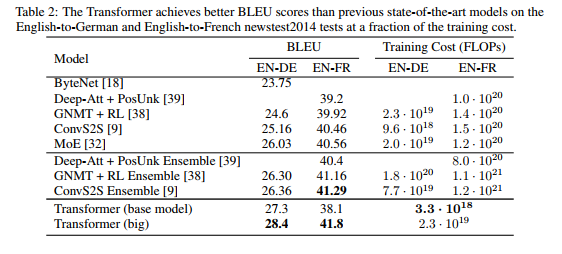

>我们在这里编写的代码是基本模型的一个版本。这里有这个系统的完全训练的版本

![](images/results.png)


> The code we have written here is a version of the base
> model. There are fully trained version of this system available
> here [(Example Models)](http://opennmt.net/Models-py/).

> With the addtional extensions in the last section, the OpenNMT-py
> replication gets to 26.9 on EN-DE WMT. Here I have loaded in those
> parameters to our reimplemenation.

通过上一节中的其他扩展，OpenNMT-py复制在EN-DE WMT上达到26.9。在这里，我已经加载了这些参数以重新实现。

In [ ]:
# Load data and model for output checks

In [ ]:
# 加载网络上训练好的模型测试
!wget https://s3.amazonaws.com/opennmt-models/en-de-model.pt

In [ ]:
model, SRC, TGT = torch.load("en-de-model.pt")

model.eval()
sent = "▁The ▁log ▁file ▁can ▁be ▁sent ▁secret ly ▁with ▁email ▁or ▁FTP ▁to ▁a ▁specified ▁receiver".split()
src = torch.LongTensor([[SRC.stoi[w] for w in sent]])
src = Variable(src)
src_mask = (src != SRC.stoi["<blank>"]).unsqueeze(-2)
out = greedy_decode(model, src, src_mask, 
                    max_len=60, start_symbol=TGT.stoi["<s>"])
print("Translation:", end="\t")
trans = "<s> "
for i in range(1, out.size(1)):
    sym = TGT.itos[out[0, i]]
    if sym == "</s>": break
    trans += sym + " "
print(trans)

In [ ]:
# 测试自己的模型
def check_outputs(
    valid_dataloader,
    model,
    vocab_src,
    vocab_tgt,
    n_examples=15,
    pad_idx=2,
    eos_string="</s>",
):
    results = [()] * n_examples
    for idx in range(n_examples):
        print("\nExample %d ========\n" % idx)
        b = next(iter(valid_dataloader))
        rb = Batch(b[0], b[1], pad_idx)
        greedy_decode(model, rb.src, rb.src_mask, 64, 0)[0]

        src_tokens = [
            vocab_src.get_itos()[x] for x in rb.src[0] if x != pad_idx
        ]
        tgt_tokens = [
            vocab_tgt.get_itos()[x] for x in rb.tgt[0] if x != pad_idx
        ]

        print(
            "Source Text (Input)        : "
            + " ".join(src_tokens).replace("\n", "")
        )
        print(
            "Target Text (Ground Truth) : "
            + " ".join(tgt_tokens).replace("\n", "")
        )
        model_out = greedy_decode(model, rb.src, rb.src_mask, 72, 0)[0]
        model_txt = (
            " ".join(
                [vocab_tgt.get_itos()[x] for x in model_out if x != pad_idx]
            ).split(eos_string, 1)[0]
            + eos_string
        )
        print("Model Output               : " + model_txt.replace("\n", ""))
        results[idx] = (rb, src_tokens, tgt_tokens, model_out, model_txt)
    return results


def run_model_example(n_examples=5):
    global vocab_src, vocab_tgt, spacy_de, spacy_en

    print("Preparing Data ...")
    _, valid_dataloader = create_dataloaders(
        torch.device("cpu"),
        vocab_src,
        vocab_tgt,
        spacy_de,
        spacy_en,
        batch_size=1,
        is_distributed=False,
    )

    print("Loading Trained Model ...")

    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.load_state_dict(
        torch.load("iwslt_model_final.pt", map_location=torch.device("cpu"))
    )

    print("Checking Model Outputs:")
    example_data = check_outputs(
        valid_dataloader, model, vocab_src, vocab_tgt, n_examples=n_examples
    )
    return model, example_data


execute_example(run_model_example)

## Attention Visualization

> Even with a greedy decoder the translation looks pretty good. We
> can further visualize it to see what is happening at each layer of
> the attention

In [ ]:
def mtx2df(m, max_row, max_col, row_tokens, col_tokens):
    "convert a dense matrix to a data frame with row and column indices"
    return pd.DataFrame(
        [
            (
                r,
                c,
                float(m[r, c]),
                "%.3d %s"
                % (r, row_tokens[r] if len(row_tokens) > r else "<blank>"),
                "%.3d %s"
                % (c, col_tokens[c] if len(col_tokens) > c else "<blank>"),
            )
            for r in range(m.shape[0])
            for c in range(m.shape[1])
            if r < max_row and c < max_col
        ],
        # if float(m[r,c]) != 0 and r < max_row and c < max_col],
        columns=["row", "column", "value", "row_token", "col_token"],
    )


def attn_map(attn, layer, head, row_tokens, col_tokens, max_dim=30):
    df = mtx2df(
        attn[0, head].data,
        max_dim,
        max_dim,
        row_tokens,
        col_tokens,
    )
    return (
        alt.Chart(data=df)
        .mark_rect()
        .encode(
            x=alt.X("col_token", axis=alt.Axis(title="")),
            y=alt.Y("row_token", axis=alt.Axis(title="")),
            color="value",
            tooltip=["row", "column", "value", "row_token", "col_token"],
        )
        .properties(height=400, width=400)
        .interactive()
    )

In [ ]:
def get_encoder(model, layer):
    return model.encoder.layers[layer].self_attn.attn


def get_decoder_self(model, layer):
    return model.decoder.layers[layer].self_attn.attn


def get_decoder_src(model, layer):
    return model.decoder.layers[layer].src_attn.attn


def visualize_layer(model, layer, getter_fn, ntokens, row_tokens, col_tokens):
    # ntokens = last_example[0].ntokens
    attn = getter_fn(model, layer)
    n_heads = attn.shape[1]
    charts = [
        attn_map(
            attn,
            0,
            h,
            row_tokens=row_tokens,
            col_tokens=col_tokens,
            max_dim=ntokens,
        )
        for h in range(n_heads)
    ]
    assert n_heads == 8
    return alt.vconcat(
        charts[0]
        # | charts[1]
        | charts[2]
        # | charts[3]
        | charts[4]
        # | charts[5]
        | charts[6]
        # | charts[7]
        # layer + 1 due to 0-indexing
    ).properties(title="Layer %d" % (layer + 1))

## Encoder Self Attention

In [ ]:
def viz_encoder_self():
    model, example_data = run_model_example(n_examples=1)
    example = example_data[
        len(example_data) - 1
    ]  # batch object for the final example

    layer_viz = [
        visualize_layer(
            model, layer, get_encoder, len(example[1]), example[1], example[1]
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        # & layer_viz[1]
        & layer_viz[2]
        # & layer_viz[3]
        & layer_viz[4]
        # & layer_viz[5]
    )


show_example(viz_encoder_self)

## Decoder Self Attention

In [ ]:
def viz_decoder_self():
    model, example_data = run_model_example(n_examples=1)
    example = example_data[len(example_data) - 1]

    layer_viz = [
        visualize_layer(
            model,
            layer,
            get_decoder_self,
            len(example[1]),
            example[1],
            example[1],
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        & layer_viz[1]
        & layer_viz[2]
        & layer_viz[3]
        & layer_viz[4]
        & layer_viz[5]
    )


show_example(viz_decoder_self)

## Decoder Src Attention

In [ ]:
def viz_decoder_src():
    model, example_data = run_model_example(n_examples=1)
    example = example_data[len(example_data) - 1]

    layer_viz = [
        visualize_layer(
            model,
            layer,
            get_decoder_src,
            max(len(example[1]), len(example[2])),
            example[1],
            example[2],
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        & layer_viz[1]
        & layer_viz[2]
        & layer_viz[3]
        & layer_viz[4]
        & layer_viz[5]
    )


show_example(viz_decoder_src)